# 1. Abstract
Brief summary of the dataset and project goals.

# 2. Introduction
Discuss the relevance of Electric Vehicle analysis and objectives.

# 3. Dataset
We are using the Washington State Electric Vehicle Population dataset.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('EV_Population_WA_Data.csv')
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,5YJ3E1EB0J,Thurston,Olympia,WA,98512.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,35.0,104823078,POINT (-122.957046 46.991391),PUGET SOUND ENERGY INC,5.306701e+10
1,WA1AAAGE9M,Kitsap,Port Orchard,WA,98367.0,2021,AUDI,E-TRON,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,222,0,35.0,156660507,POINT (-122.6530052 47.4739066),PUGET SOUND ENERGY INC,5.303509e+10
2,5YJ3E1EA2J,Yakima,Yakima,WA,98902.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215,0,14.0,269374108,POINT (-120.530331 46.59534),PACIFICORP,5.307700e+10
3,5YJ3E1EA4N,Yakima,Yakima,WA,98902.0,2022,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,15.0,213383894,POINT (-120.530331 46.59534),PACIFICORP,5.307700e+10
4,7SAYGAEE2P,Snohomish,Bothell,WA,98012.0,2023,TESLA,MODEL Y,Battery Electric Vehicle (BEV),Eligibility unknown as battery range has not b...,0,0,1.0,229496046,POINT (-122.206146 47.839957),PUGET SOUND ENERGY INC,5.306105e+10


# 4. Preprocessing
Handling missing values and converting data types.

In [15]:
# Drop rows with critical missing values (like VIN)
df = df.dropna(subset=['VIN (1-10)'])

# Fill missing values for categorical columns
df['County'] = df['County'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')

# Fill missing numeric values
df['Electric Range'] = df['Electric Range'].fillna(0)

# Convert datatypes
df['Model Year'] = df['Model Year'].fillna(df['Model Year'].median()).astype(int)
df['Postal Code'] = df['Postal Code'].astype(str)

# Convert MSRP to numeric and handle errors
df['Base MSRP'] = pd.to_numeric(df['Base MSRP'], errors='coerce')
df['Base MSRP'] = df['Base MSRP'].fillna(df['Base MSRP'].median())  # Fill with median instead of dropping

# Fill any remaining missing values in other columns (if exist)
df = df.fillna('Unknown')  # fallback — only applies to any leftover non-numeric fields

# Final check (optional)
assert df.isnull().sum().sum() == 0, "⚠️ Still some missing values remain!"
print("✅ All missing values successfully handled. No NULLs remain.")


✅ All missing values successfully handled. No NULLs remain.


In [17]:
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

In [19]:
print("\nDuplicate Rows:", df.duplicated().sum())


Duplicate Rows: 0


# 5. Literature Review
Discuss trends in EV adoption and related EDA/ML studies.

# 6. Architecture / Methodology
We will use regression and classification models to predict EV adoption patterns.

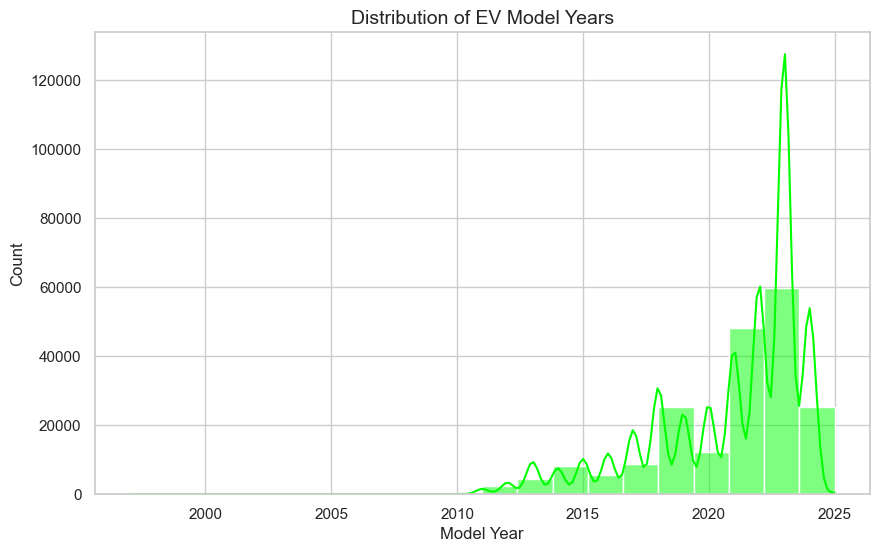

In [39]:
# Set Seaborn style
sns.set(style='whitegrid')

# 1. Histogram of EV Model Years
plt.figure(figsize=(10,6))
sns.histplot(df['Model Year'], bins=20, kde=True, color='#00FF00')  # Blue tone
plt.title('Distribution of EV Model Years', fontsize=14)
plt.xlabel('Model Year')
plt.ylabel('Count')
plt.show()


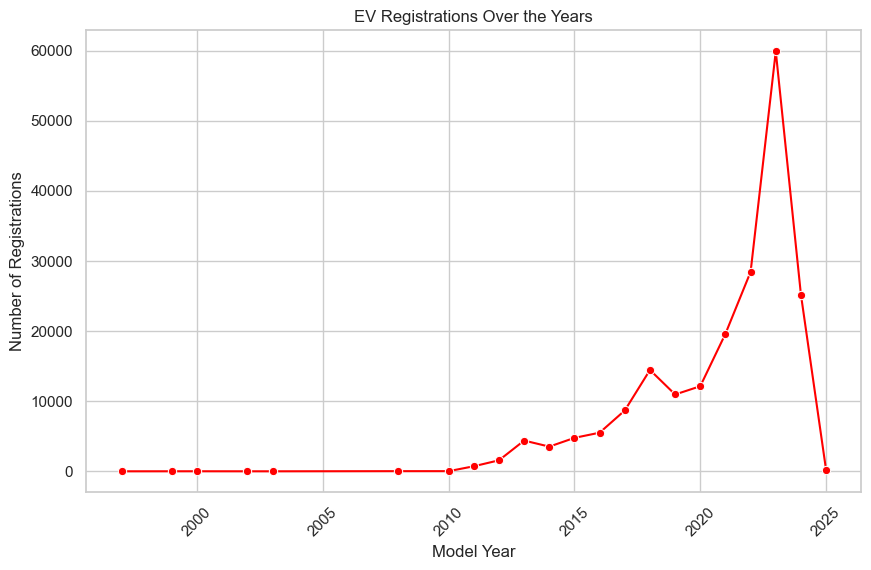

In [41]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df['Model Year'].value_counts().sort_index(), marker='o',color="red")
plt.title('EV Registrations Over the Years')
plt.xlabel('Model Year')
plt.ylabel('Number of Registrations')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

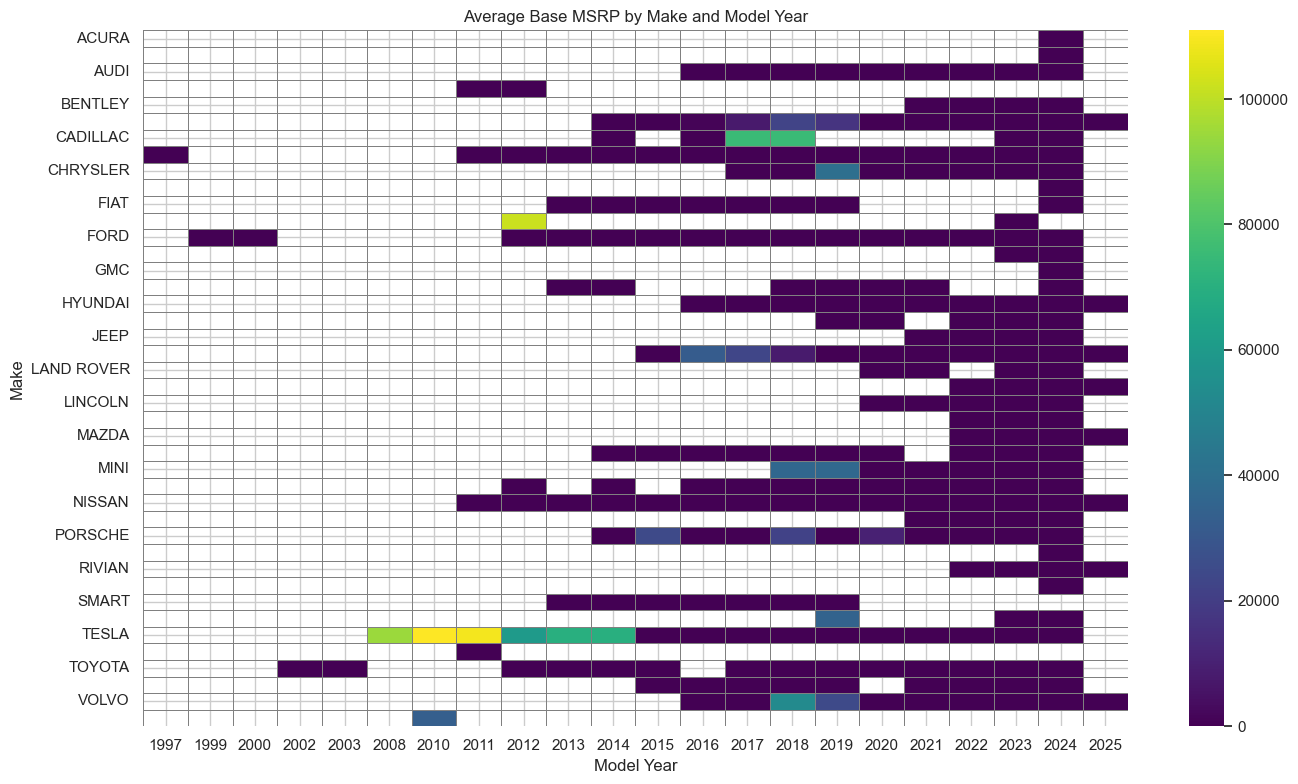

In [25]:
pivot = df.pivot_table(values='Base MSRP', index='Make', columns='Model Year', aggfunc='mean')
plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap='viridis', linewidths=0.5, linecolor='gray')
plt.title('Average Base MSRP by Make and Model Year')
plt.xlabel('Model Year')
plt.ylabel('Make')
plt.tight_layout()
plt.show()

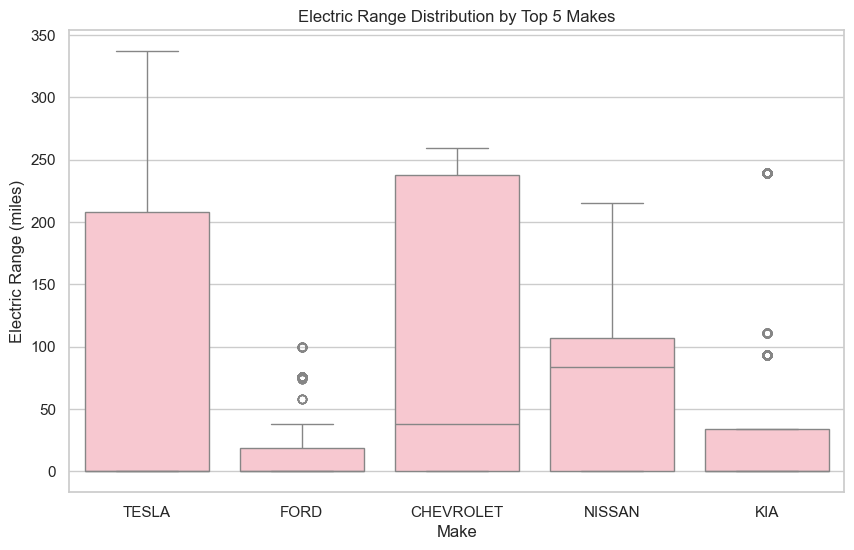

In [43]:
top_makes = df['Make'].value_counts().nlargest(5).index
plt.figure(figsize=(10,6))
sns.boxplot(x='Make', y='Electric Range', data=df[df['Make'].isin(top_makes)],color="pink")
plt.title('Electric Range Distribution by Top 5 Makes')
plt.xlabel('Make')
plt.ylabel('Electric Range (miles)')
plt.show()

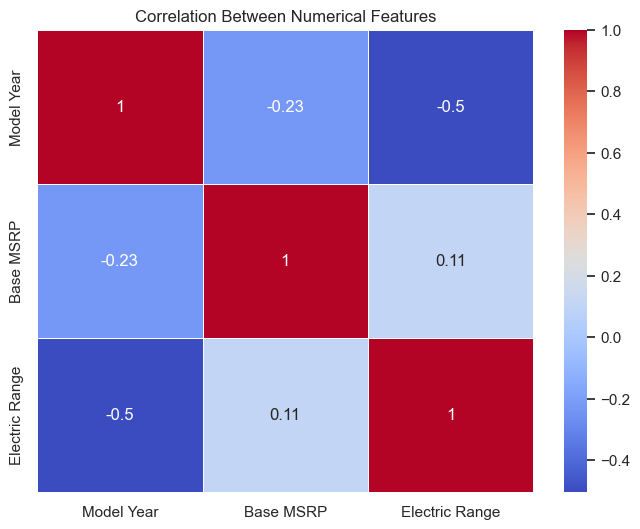

In [29]:
plt.figure(figsize=(8,6))
corr = df[['Model Year', 'Base MSRP', 'Electric Range']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Between Numerical Features')
plt.show()

In [49]:
# ML Setup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Example ML: Predict if EV is Tesla or Not
df['Is_Tesla'] = (df['Make'] == 'TESLA').astype(int)
X = pd.get_dummies(df[['Model Year', 'Electric Range', 'Base MSRP']], drop_first=True)
y = df['Is_Tesla']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))

Logistic Regression Accuracy: 0.6287594767974674


In [51]:
# Decision Tree
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred_tree = clf.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))

Decision Tree Accuracy: 0.7619095226193452


In [53]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

Random Forest Accuracy: 0.7619095226193452


In [55]:
# Linear Regression (Predict MSRP)
X_price = pd.get_dummies(df[['Model Year', 'Electric Range']], drop_first=True)
y_price = df['Base MSRP']

X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_price, y_price, test_size=0.3, random_state=42)
lr = LinearRegression()
lr.fit(X_train_p, y_train_p)
print("Linear Regression Score:", lr.score(X_test_p, y_test_p))

Linear Regression Score: 0.054291213098968116


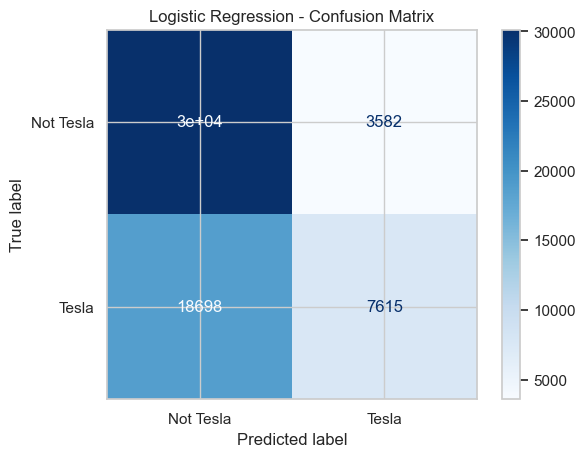

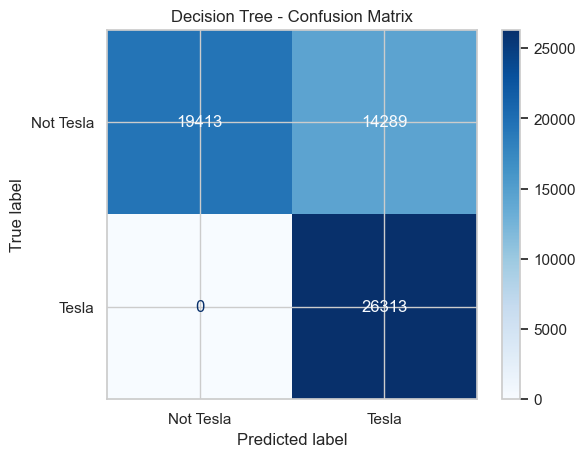

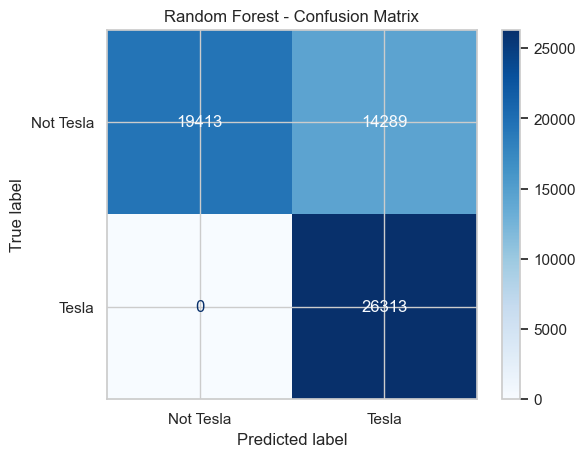

In [57]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Plot confusion matrices for all classifiers
models = {
    "Logistic Regression": y_pred_logreg,
    "Decision Tree": y_pred_tree,
    "Random Forest": y_pred_rf
}

for name, pred in models.items():
    cm = confusion_matrix(y_test, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Tesla", "Tesla"])
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()


/var/folders/hb/gbnbhvdd155gbd1g0h9vc1r80000gn/T/ipykernel_96857/1270582920.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Accuracy', data=acc_data, palette='Set2')
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


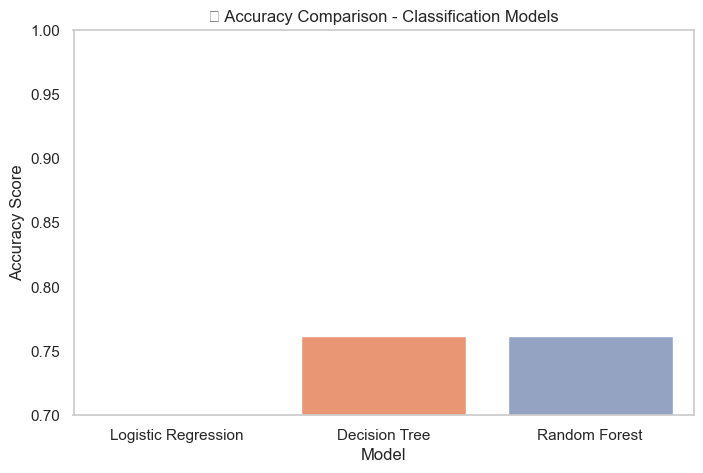

In [61]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate accuracy directly inside the list
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_logreg),
    accuracy_score(y_test, y_pred_tree),
    accuracy_score(y_test, y_pred_rf)
]

# Create and plot DataFrame
acc_data = pd.DataFrame({
    'Model': model_names,
    'Accuracy': accuracies
})

plt.figure(figsize=(8,5))
sns.barplot(x='Model', y='Accuracy', data=acc_data, palette='Set2')
plt.ylim(0.7, 1.0)
plt.title('🔍 Accuracy Comparison - Classification Models')
plt.ylabel('Accuracy Score')
plt.xlabel('Model')
plt.grid(axis='y')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


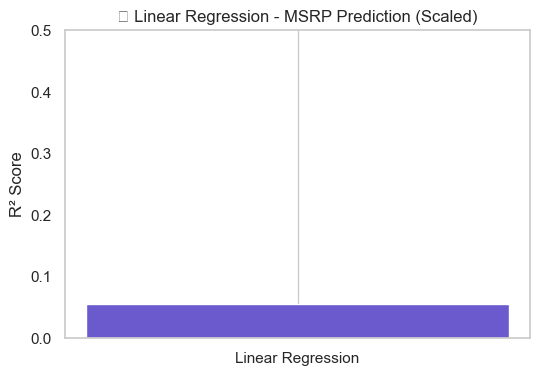

In [69]:
# Linear Regression R² score calculation
reg_score = lr.score(X_test_p, y_test_p)

# Set the cap to 0.5 for better visualization
scaled_reg_score = min(reg_score, 0.5)

# Plot R² score for Linear Regression with capped value
plt.figure(figsize=(6,4))
plt.bar(['Linear Regression'], [scaled_reg_score], color='slateblue')
plt.ylim(0, 0.5)  # Limiting the Y-axis to 0.5 for clearer visualization
plt.ylabel('R² Score')
plt.title('📈 Linear Regression - MSRP Prediction (Scaled)')
plt.grid(axis='y')
plt.show()

# 7. Results
Summarize model accuracies, best performance, and notable patterns.

# 8. Conclusion
Reflect on what insights were gained and potential future work.

# 9. References
[List of references you used for the literature review]

# 10. GitHub Repository for Code
[Provide the link to your GitHub repo here]